Project : Image Denoising using Markov Random Field
```
Team members: Yaswanth Yadav Korrayi 18CE3AI18
              Akula Vikram  18AG3AI07
              Aditya Ramesh Chakole 18CE3AI15
              Indraja Purushottham 18AE30014
              Hrusita Yadla 18AE30027

```




In [146]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from torch.optim import RMSprop

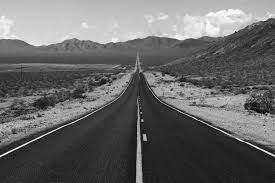

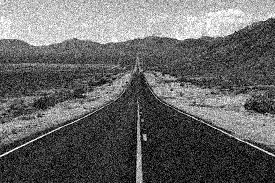

In [147]:
import cv2
import numpy as np
from scipy.stats.kde import gaussian_kde
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# original image
f = cv2.imread('/content/road_nosiseless.png',0)


cv2_imshow(f)
cv2.waitKey(0)
cv2.destroyAllWindows()
gt = f
f = f/255 
# create gaussian noise
x, y = f.shape
mean = 0
var = 0.01
sigma = np.sqrt(var)
n = np.random.normal(loc=mean, 
                     scale=sigma, 
                     size=(x,y))
# add a gaussian noise
g = f + n
noisy = g
g = g*255
cv2_imshow(g)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [148]:
to_tensor = ToTensor()
noisy = to_tensor(noisy)[0].cuda()
gt    = to_tensor(gt)[0].cuda()

In [149]:
def mrf_prior(x):
    return x**2

def mrf_potential(X, noisy, a):
    # energy_1 is reconstruction loss
    energy_1 = ((noisy - X)**2).sum()
    # energy_2 defines neighbourhood potentials
    energy_2 = 0
    energy_2 += mrf_prior(X[:, 1: ] - X[:, :-1]).sum()
    energy_2 += mrf_prior(X[:-1, :] - X[ 1:, :]).sum()
    energy_2 += mrf_prior(X[:-1,:-1] - X[1:, 1:]).sum()
    energy_2 += mrf_prior(X[1:, :-1] - X[ :-1, 1:]).sum()
    return energy_1 + a*energy_2*2

In [150]:
to_tensor = ToTensor()
RRMSE = lambda x: (((gt - x)**2).sum() / (gt**2).sum())**0.5
# X = noisy.clone().cuda()
X = torch.zeros_like(noisy).cuda()
X.requires_grad = True
errors = []
losses = []
images = []
alpha  = 0.15
optimizer = RMSprop([X])
n_it   = 100

In [151]:
g = to_tensor(g)[0].cuda()
RRMSE(g).cpu().detach()

tensor(259.0963, dtype=torch.float64)

In [152]:
for it in range(n_it):
    optimizer.zero_grad()
    loss = mrf_potential(X, noisy, alpha)
    loss.backward()
    optimizer.step()
    errors.append(RRMSE(X).cpu().detach())
    losses.append(loss.item())
    images.append(np.array(X.cpu().detach()).astype(np.uint8))

RRMSE Initial: 0.2108721748773314
RRMSE Final  : 0.11953904978361538


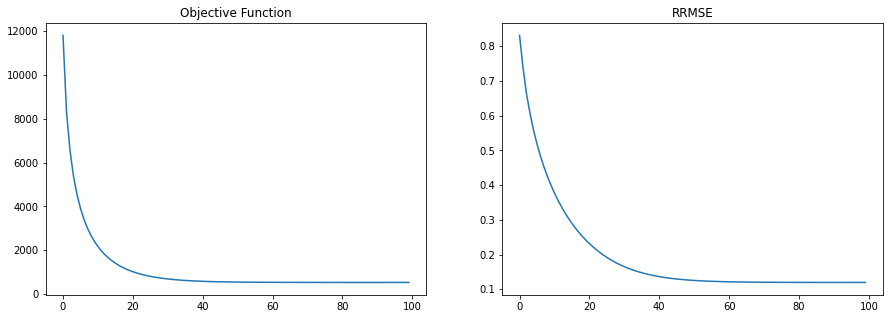

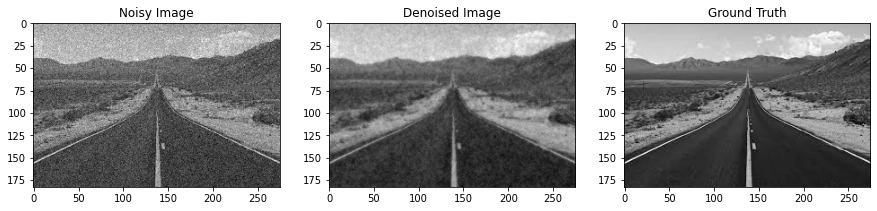

In [153]:
print("RRMSE Initial: {}".format(RRMSE(noisy)))
print("RRMSE Final  : {}".format(errors[-1]))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Objective Function')
plt.plot(losses)
plt.subplot(122)
plt.title('RRMSE')
plt.plot(errors)
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Noisy Image')
plt.imshow(noisy.cpu(), cmap='gray')
plt.subplot(132)
plt.title('Denoised Image')
plt.imshow(X.detach().cpu(), cmap='gray')
plt.subplot(133)
plt.title('Ground Truth')
plt.imshow(gt.cpu(), cmap='gray')
plt.show()